## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller

import pmdarima as pm
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Check first option with all exogenous variables

In [2]:
exog_train_df = pd.read_csv("../output/data_cleaning/arimax/1_exog_train_arimax.csv").set_index(['year'])
exog_test_df = pd.read_csv("../output/data_cleaning/arimax/1_exog_test_arimax.csv").set_index(['year'])
y_train_df = pd.read_csv("../output/data_cleaning/arimax/y_train_arimax.csv").set_index(['year'])
y_test_df = pd.read_csv("../output/data_cleaning/arimax/y_test_arimax.csv").set_index(['year'])

In [3]:
y_train_df

,country_index,co2_including_luc
year,,
1929,Argentina,242.878
1930,Argentina,194.678
1931,Argentina,163.215
1932,Argentina,145.940
1933,Argentina,134.144
...,...,...
2003,Vietnam,227.212
2004,Vietnam,246.341
2005,Vietnam,206.696


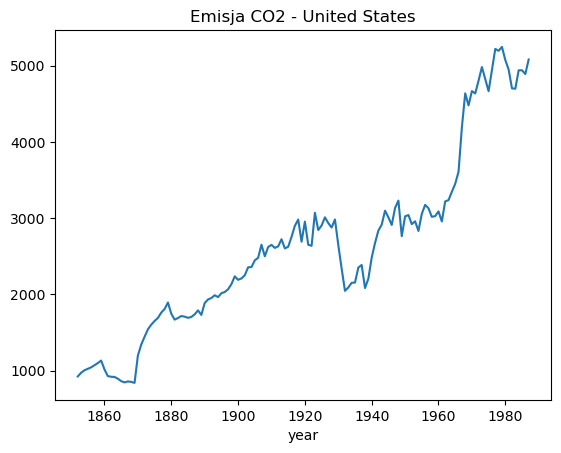

In [4]:
# Visualize the example data (eg. Poland)
y_train_df[y_train_df['country_index'] == 'United States']['co2_including_luc'].plot(title='Emisja CO2 - United States')
plt.show()

## Check seasonal

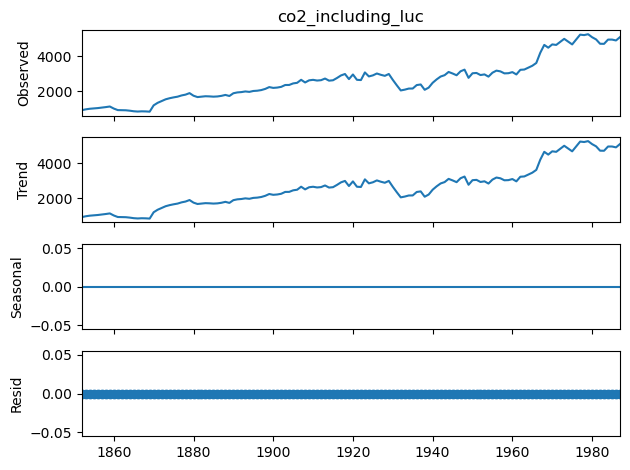

In [5]:
# Convert 'year' to DatetimeIndex
plt.close('all')

df_us = pd.concat([exog_train_df, y_train_df['co2_including_luc']], axis=1)
df_us = df_us[df_us['country_index'] == 'United States'].copy()
df_us.index = pd.to_datetime(df_us.index, format='%Y')

result = seasonal_decompose(df_us['co2_including_luc'])
fig = result.plot()
fig.axes[0].set_ylabel('Observed')
plt.show()

## Check stationarity

In [6]:
#check stationarity
def adf_test(series,title=''):

    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC')
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string()) 
    
    if result[1] <= 0.05:
        print("Data are stationary")
    else:
        print("Data are non-stationary")
     

In [7]:
adf_test(df_us['co2_including_luc'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -0.000649
p-value                   0.958478
# lags used               0.000000
# observations          135.000000
critical value (1%)      -3.479743
critical value (5%)      -2.883198
critical value (10%)     -2.578320
Data are non-stationary


In [8]:
df_us_diff = df_us['co2_including_luc'].diff(1)

In [9]:
adf_test(df_us_diff)

Augmented Dickey-Fuller Test: 
ADF test statistic     -5.660442e+00
p-value                 9.406824e-07
# lags used             2.000000e+00
# observations          1.320000e+02
critical value (1%)    -3.480888e+00
critical value (5%)    -2.883697e+00
critical value (10%)   -2.578586e+00
Data are stationary


## Find the parameters of the model

In [10]:
# Dictionary to store the models and parameters for each country
auto_arima_models = {}

countries = exog_train_df['country_index'].unique()

for country in countries:
    exog_train_country = exog_train_df[exog_train_df['country_index'] == country].drop(columns=['country_index'])
    y_train_country = y_train_df[y_train_df['country_index'] == country]['co2_including_luc']

    auto_model = pm.auto_arima(y_train_country, 
                               exogenous=exog_train_country,
                               start_p=1, 
                               start_q=1,
                               max_p=5, 
                               max_q=5, 
                               seasonal=False,
                               d=1,  
                               trace=False,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
    
    auto_arima_models[country] = {
        'order': auto_model.order,
    }

auto_arima_models

{'Argentina': {'order': (0, 1, 1)},
 'Australia': {'order': (1, 1, 0)},
 'Belarus': {'order': (0, 1, 0)},
 'Belgium': {'order': (0, 1, 0)},
 'Brazil': {'order': (0, 1, 0)},
 'Canada': {'order': (0, 1, 0)},
 'Chile': {'order': (0, 1, 0)},
 'China': {'order': (1, 1, 0)},
 'Colombia': {'order': (0, 1, 1)},
 "Cote d'Ivoire": {'order': (0, 1, 0)},
 'Czechia': {'order': (1, 1, 0)},
 'Democratic Republic of Congo': {'order': (0, 1, 0)},
 'Egypt': {'order': (0, 1, 0)},
 'France': {'order': (0, 1, 0)},
 'Germany': {'order': (0, 1, 0)},
 'India': {'order': (1, 1, 0)},
 'Indonesia': {'order': (0, 1, 0)},
 'Iran': {'order': (0, 1, 0)},
 'Italy': {'order': (0, 1, 0)},
 'Japan': {'order': (1, 1, 1)},
 'Kazakhstan': {'order': (0, 1, 0)},
 'Malaysia': {'order': (4, 1, 0)},
 'Mexico': {'order': (1, 1, 2)},
 'Netherlands': {'order': (0, 1, 0)},
 'Nigeria': {'order': (1, 1, 1)},
 'Pakistan': {'order': (1, 1, 0)},
 'Peru': {'order': (0, 1, 0)},
 'Philippines': {'order': (0, 1, 0)},
 'Poland': {'order': (2

In [11]:
sarimax_models = {}

for country in countries:
    exog_train_country = exog_train_df[exog_train_df['country_index'] == country].drop(columns=['country_index'])
    y_train_country = y_train_df[y_train_df['country_index'] == country]['co2_including_luc']
    
    order = auto_arima_models[country]['order']
    
    model = sm.tsa.SARIMAX(y_train_country, 
                           exog=exog_train_country, 
                           order=order, 
                           enforce_invertibility=False)
    results = model.fit(disp=False)

    sarimax_models[country] = {
        'model': model,
        'results': results,
        'summary': results.summary()
    }

/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An u

### Prediction - test set

In [12]:
results_test_list = []

for country in countries:
    exog_test_country = exog_test_df[exog_test_df['country_index'] == country].drop(columns=['country_index'])
    y_test_country = y_test_df[y_test_df['country_index'] == country]['co2_including_luc']
    
    exog_train_country = exog_train_df[exog_train_df['country_index'] == country].drop(columns=['country_index'])
    y_train_country = y_train_df[y_train_df['country_index'] == country]['co2_including_luc']

    results_test = sarimax_models[country]['results']

    y_pred = results_test.predict(
        start=len(y_train_country),
        end=len(y_train_country) + len(exog_test_country) - 1,
        exog=exog_test_country
    )

    df_results = pd.DataFrame({
        'year': exog_test_country.index,
        'country': country,
        'predicted': y_pred.values,
        'actual': y_test_country.values
    })

    results_test_list.append(df_results)

final_results_test_df = pd.concat(results_test_list, ignore_index=True).set_index(['year'])
final_results_test_df

/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index wi

,country,predicted,actual
year,,,
2004,Argentina,380.098579,450.881
2005,Argentina,371.978293,487.442
2006,Argentina,383.823313,505.851
2007,Argentina,380.488570,353.365
2008,Argentina,353.516735,293.438
...,...,...,...
2018,Vietnam,77.412430,504.751
2019,Vietnam,54.559383,589.843
2020,Vietnam,254.562686,613.079


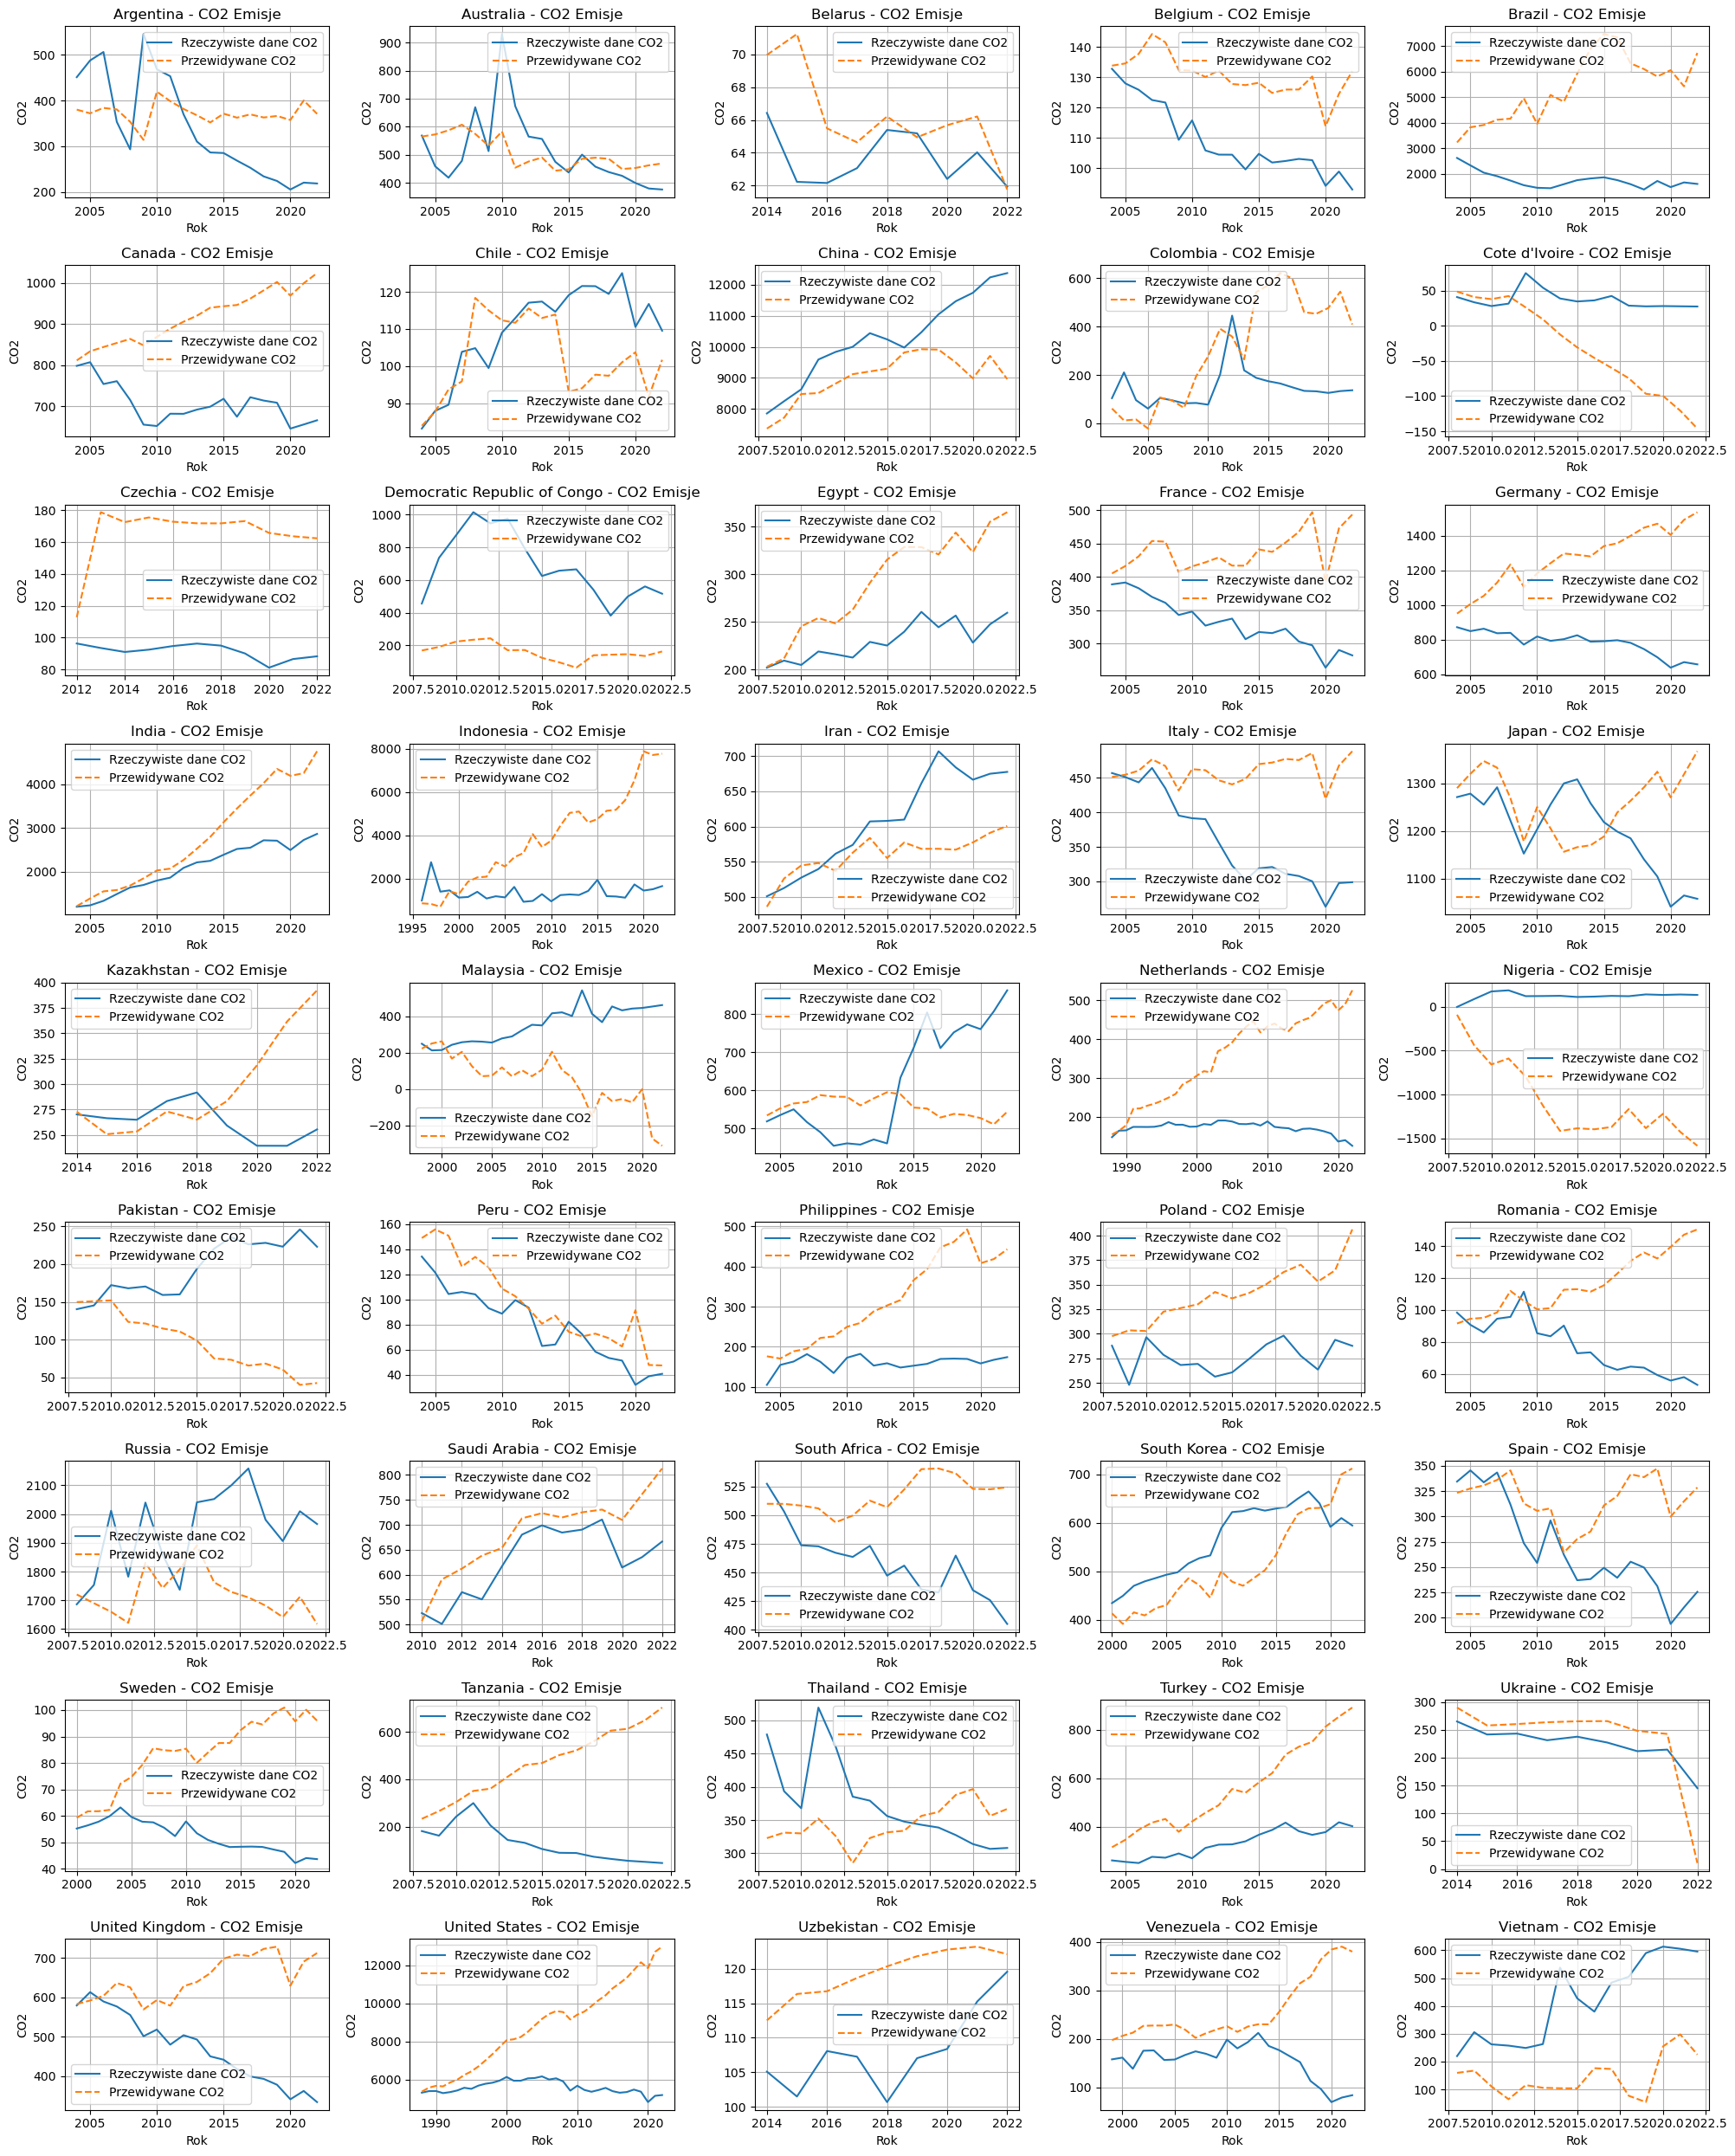

In [13]:
num_rows = 9
num_cols = 5


fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 25), squeeze=False)
axes = axes.flatten()

for i, country in enumerate(countries):
    country_results = final_results_test_df[final_results_test_df['country'] == country]
    ax = axes[i]
    
    ax.plot(country_results.index, country_results['actual'], label='Rzeczywiste dane CO2')
    ax.plot(country_results.index, country_results['predicted'], label='Przewidywane CO2', linestyle='--')
    
    ax.set_title(f'{country} - CO2 Emisje')
    ax.set_xlabel('Rok')
    ax.set_ylabel('CO2')
    ax.grid(True)
    
    ax.legend()

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Predict - train set

In [14]:
results_train_list = []

for country in countries:
    exog_train_country = exog_train_df[exog_train_df['country_index'] == country].drop(columns=['country_index'])
    y_train_country = y_train_df[y_train_df['country_index'] == country]['co2_including_luc']

    results_train = sarimax_models[country]['results']

    y_pred = results_train.predict(
        start=0,
        end=len(y_train_country) - 1,
        exog=exog_train_country
    )

    df_results = pd.DataFrame({
        'year': exog_train_country.index,
        'country': country,
        'predicted': y_pred.values,
        'actual': y_train_country.values
    })

    results_train_list.append(df_results)

final_results_train_df = pd.concat(results_train_list, ignore_index=True).set_index(['year'])
final_results_train_df


,country,predicted,actual
year,,,
1929,Argentina,229.649096,242.878
1930,Argentina,243.633802,194.678
1931,Argentina,184.159874,163.215
1932,Argentina,154.700351,145.940
1933,Argentina,143.253569,134.144
...,...,...,...
2003,Vietnam,173.452009,227.212
2004,Vietnam,235.880164,246.341
2005,Vietnam,243.354624,206.696


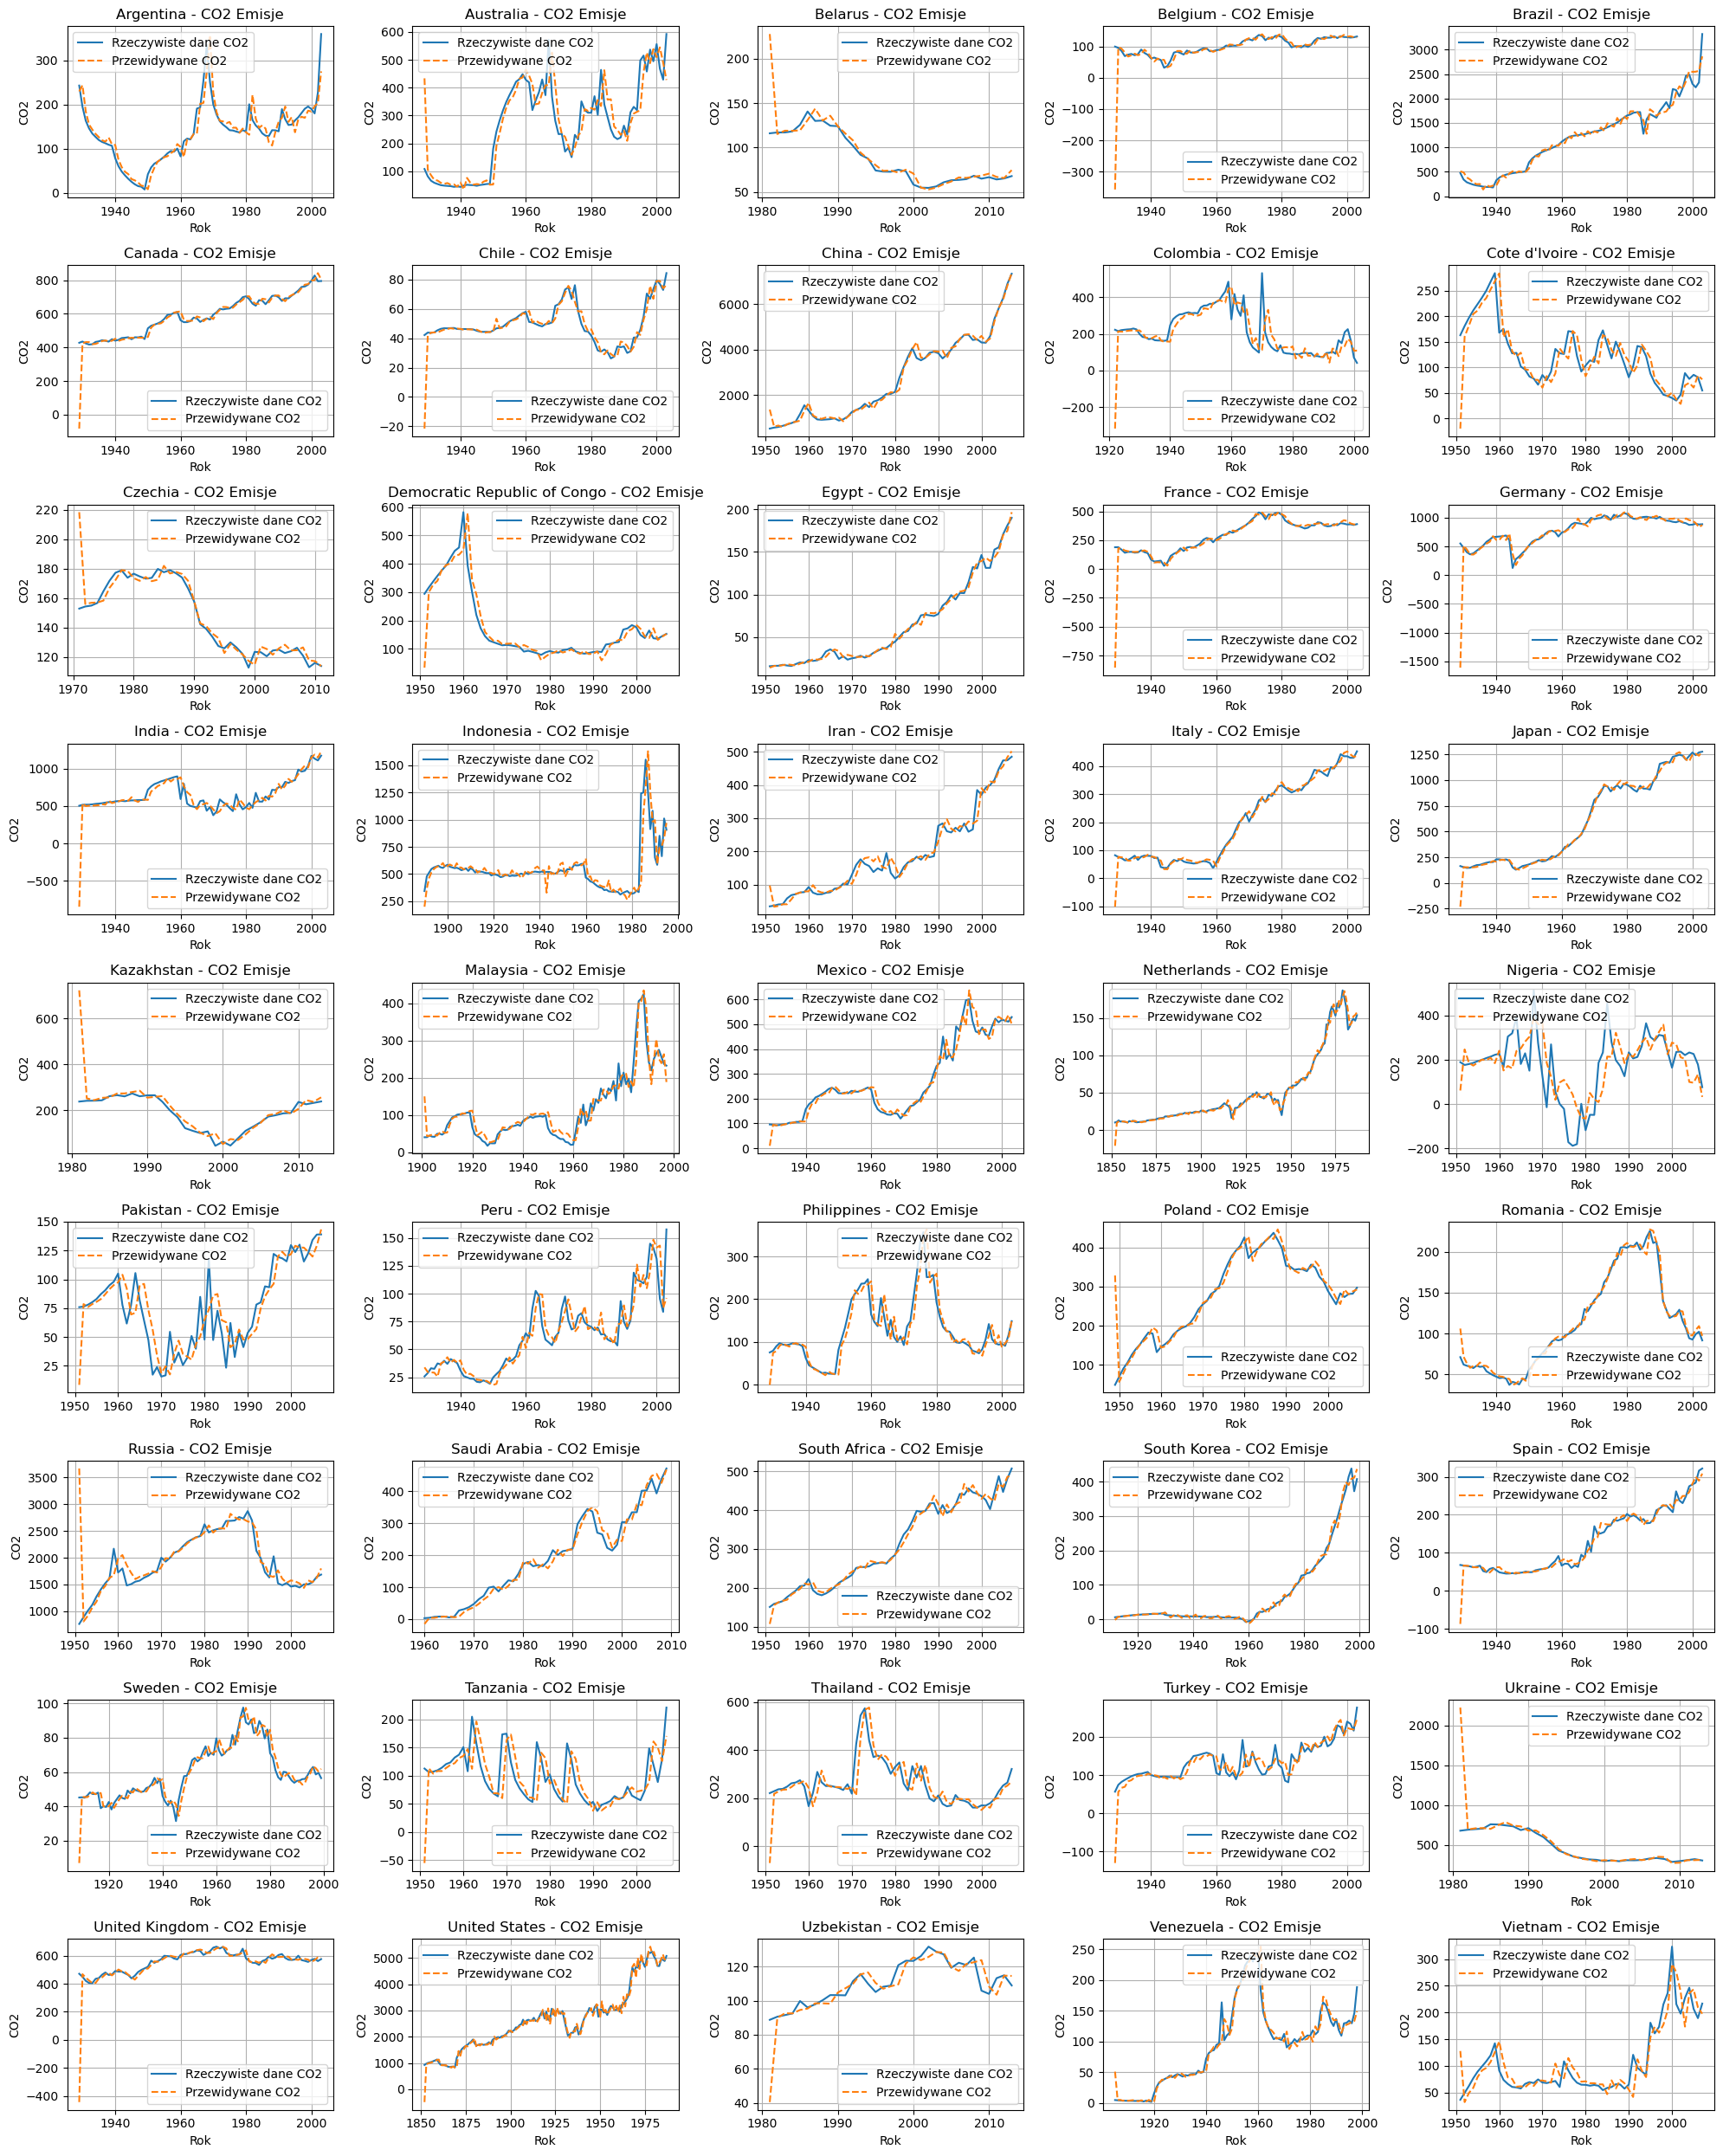

In [15]:
num_rows = 9
num_cols = 5

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 25), squeeze=False)
axes = axes.flatten()

for i, country in enumerate(countries):
    country_results = final_results_train_df[final_results_train_df['country'] == country]
    ax = axes[i]
    
    ax.plot(country_results.index, country_results['actual'], label='Rzeczywiste dane CO2')
    ax.plot(country_results.index, country_results['predicted'], label='Przewidywane CO2', linestyle='--')
    
    ax.set_title(f'{country} - CO2 Emisje')
    ax.set_xlabel('Rok')
    ax.set_ylabel('CO2')
    ax.grid(True)
    
    ax.legend()

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Check metrics - test set

In [16]:
y_true = final_results_test_df['actual']
y_pred = final_results_test_df['predicted']

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

# Print metrics
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}%')
print(f'R²: {r2}')

RMSE: 1231.9848932034868
MAE: 490.1614989352181
MAPE: 88.25483314502674%
R²: 0.5006164550943966


In [17]:
metrics_by_country = []


for country in final_results_test_df['country'].unique():
    country_data = final_results_test_df[final_results_test_df['country'] == country]

    y_true = country_data['actual']
    y_pred = country_data['predicted']
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    
    metrics_by_country.append({
        'Country': country,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE (%)': mape,
        'R²': r2
    })

metrics_df = pd.DataFrame(metrics_by_country)
metrics_df

,Country,RMSE,MAE,MAPE (%),R²
0,Argentina,114.401453,100.732194,34.445776,-0.096614
1,Australia,119.389164,86.187278,15.937440,0.145454
2,Belarus,3.712162,2.689147,4.257080,-4.529939
3,Belgium,22.984659,21.525155,20.564363,-2.998047
4,Brazil,3887.849508,3623.648702,219.416483,-164.667519
5,Canada,231.407664,210.701326,30.694076,-24.247687
6,Chile,15.127480,11.407435,9.922955,-0.641730
7,China,1573.524821,1257.088808,11.466571,-0.426983
8,Colombia,260.349217,209.401358,150.801443,-9.577039
9,Cote d'Ivoire,90.652786,73.813892,232.971139,-52.046211
